In [1]:
# 准备数据集:下载数据集并解压到 mmsegmentation/data 目录下，由于训练和测试的图片名称混乱，需进行统一命名
import os
from PIL import Image
os.chdir('mmsegmentation')

In [2]:
# 0.1 统一命名
raw_img_path = 'data/Watermelon87_Semantic_Seg_Mask/img_dir/'
raw_label_path = 'data/Watermelon87_Semantic_Seg_Mask/ann_dir/'
new_img_path = 'data/Watermelon87/imgs/'
new_label_path = 'data/Watermelon87/labels/'
if not os.path.exists(new_img_path):
    os.makedirs(new_img_path + 'train/')
    os.makedirs(new_img_path + 'val/')
if not os.path.exists(new_label_path):
    os.makedirs(new_label_path + 'train/')
    os.makedirs(new_label_path + 'val/')

train_img_list = os.listdir(raw_img_path + 'train/')
train_label_list = os.listdir(raw_label_path + 'train/')
val_img_list = os.listdir(raw_img_path + 'val/')
val_label_list = os.listdir(raw_label_path + 'val/')
train_img_list.sort()
train_label_list.sort()
val_img_list.sort()
val_label_list.sort()


train_num = len(train_img_list)
val_num = len(val_img_list)

In [3]:
# 将图片统一命名成编号，并化成png格式
for i, img, label in zip(range(train_num), train_img_list, train_label_list):
#     print(i,img,label)
    im = Image.open(raw_img_path + 'train/' + img)
    im.save(new_img_path + 'train/' + str(i+1).zfill(2) + '.png','png')
    im = Image.open(raw_label_path + 'train/' + label)
    im.save(new_label_path + 'train/' + str(i+1).zfill(2) + '.png','png')

for i, img, label in zip(range(val_num), val_img_list, val_label_list):
    im = Image.open(raw_img_path + 'val/' + img)
    im.save(new_img_path + 'val/' + str(i+train_num+1).zfill(2) + '.png','png')
    im = Image.open(raw_label_path + 'val/' + label)
    im.save(new_label_path + 'val/' + str(i+train_num+1).zfill(2) + '.png','png')

In [4]:
# 0.2 随机查看训练集上的图片和标签
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import random


In [5]:
# 检查所有训练集图片
# for num in range(1, train_num+1):
#     img_path = new_img_path + 'train/' + str(num).zfill(2) + '.png'
#     label_path = new_label_path + 'train/' + str(num).zfill(2) + '.png' 
#     img = cv2.imread(img_path)
#     label = cv2.imread(label_path)
#     print(img.shape)
#     plt.imshow(label[:,:,0])
#     plt.axis('off')
#     plt.show()
#     plt.imshow(img[:,:,::-1])
#     plt.imshow(label[:,:,0], alpha=0.5) # alpha 高亮区域透明度，越小越接近原图
#     plt.axis('off')
#     plt.show()

In [6]:
# 检查所有验证集图片
# for num in range(train_num+1, train_num+val_num+1):
#     img_path = new_img_path + 'val/' + str(num).zfill(2) + '.png'
#     label_path = new_label_path + 'val/' + str(num).zfill(2) + '.png' 
#     img = cv2.imread(img_path)
#     label = cv2.imread(label_path)
#     print(img.shape)
#     plt.imshow(label[:,:,0])
#     plt.axis('off')
#     plt.show()
#     plt.imshow(img[:,:,::-1])
#     plt.imshow(label[:,:,0], alpha=0.5) # alpha 高亮区域透明度，越小越接近原图
#     plt.axis('off')
#     plt.show()

(400, 600, 3)


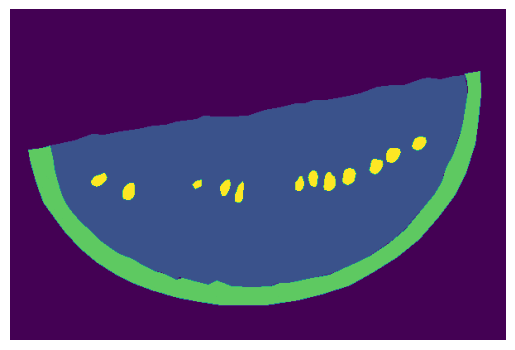

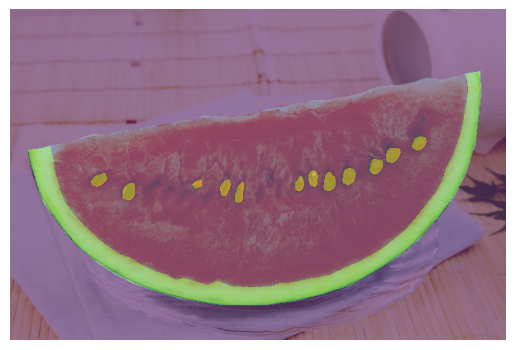

In [7]:
num = random.randint(0, train_num)
img_path = new_img_path + 'train/' + str(num).zfill(2) + '.png'
label_path = new_label_path + 'train/' + str(num).zfill(2) + '.png' 
img = cv2.imread(img_path)
label = cv2.imread(label_path)
print(img.shape)
plt.imshow(label[:,:,0])
plt.axis('off')
plt.show()
plt.imshow(img[:,:,::-1])
plt.imshow(label[:,:,0], alpha=0.5) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.show()

In [8]:
# 1.1 PSPNet的配置文件 
# 定义数据集
config_dataset_watermelon87 = '''
from mmseg.registry import DATASETS
from .basesegdataset import BaseSegDataset

@DATASETS.register_module()
class Watermelon87Dataset(BaseSegDataset):
    # 类别和对应的可视化配色
    METAINFO = {
        'classes':['red', 'green', 'white', 'seed-black', 'seed-white', 'unlabeled'],
        'palette':[[64,68,132], [63,118,139], [125,198,113], [142,209,101], [245,231,89], [61,9,83]]
    }
    
    # 指定图像扩展名、标注扩展名
    def __init__(self,
                 img_suffix='.png',
                 seg_map_suffix='.png',
                 reduce_zero_label=False, # 类别ID为0的类别是否需要除去
                 **kwargs) -> None:
        super().__init__(
            img_suffix=img_suffix,
            seg_map_suffix=seg_map_suffix,
            reduce_zero_label=reduce_zero_label,
            **kwargs)

'''
with open('mmseg/datasets/Watermelon87Dataset.py', 'w') as f:
    f.write(config_dataset_watermelon87)

In [9]:
# 注册数据集类
# 修改mmseg/datasets/__init__.py文件
# 头文件中加入 from .Watermelon87Dataset import Watermelon87Dataset
# __all__ 中加入 Watermelon87Dataset

In [10]:
# 定义训练和测试pipeline
config_watermelon87dataset_pipeline = '''
# dataset settings
dataset_type = 'Watermelon87Dataset' # 数据集类名
data_root = 'data/Watermelon87/' # 数据集路径（相对于mmsegmentation主目录）
crop_size = (64, 64)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(
        type='RandomResize',
        scale=(2048, 1024),
        ratio_range=(0.5, 2.0),
        keep_ratio=True),
    dict(type='RandomCrop', crop_size=crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2048, 1024), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]
img_ratios = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
tta_pipeline = [
    dict(type='LoadImageFromFile', file_client_args=dict(backend='disk')),
    dict(
        type='TestTimeAug',
        transforms=[
            [
                dict(type='Resize', scale_factor=r, keep_ratio=True)
                for r in img_ratios
            ],
            [
                dict(type='RandomFlip', prob=0., direction='horizontal'),
                dict(type='RandomFlip', prob=1., direction='horizontal')
            ], [dict(type='LoadAnnotations')], [dict(type='PackSegInputs')]
        ])
]
train_dataloader = dict(
    batch_size=2,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='InfiniteSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(
            img_path='imgs/train', seg_map_path='labels/train'),
        pipeline=train_pipeline))
val_dataloader = dict(
    batch_size=1,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(
            img_path='imgs/val', seg_map_path='labels/val'),
        pipeline=test_pipeline))
test_dataloader = val_dataloader

val_evaluator = dict(type='IoUMetric', iou_metrics=['mIoU'])
test_evaluator = val_evaluator
'''
with open('configs/_base_/datasets/Watermelon87Dataset_pipeline.py', 'w') as f:
    f.write(config_watermelon87dataset_pipeline)


In [11]:
# 模型配置文件
config_watermelon = """
_base_ = [
    '../_base_/models/pspnet_r50-d8.py', '../_base_/datasets/Watermelon87Dataset_pipeline.py',
    '../_base_/default_runtime.py', '../_base_/schedules/schedule_40k.py'
]

# crop_size = (64, 64) # 输入图像尺寸，根据自己数据集情况修改
# data_preprocessor = dict(size=crop_size)
# model = dict(data_preprocessor=data_preprocessor)
"""

with open('configs/pspnet/pspnet_r50-d8_4xb2-40k_watermelon.py', 'w') as f:
    f.write(config_watermelon)

In [12]:
# 1.2 训练模型
import numpy as np
import os.path as osp
from tqdm import tqdm
import mmcv
import mmengine

In [13]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_watermelon.py')

cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader

# 结果保存目录
cfg.work_dir = './work_dirs/Watermelon87Dataset'

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1500
# 随机数种子
cfg['randomness'] = dict(seed=0)

In [14]:
# 保存配置文件
cfg.dump('pspnet-Watermelon87Dataset.py')

In [15]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)


06/14 21:05:04 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3080 Ti
    CUDA_HOME: /usr/local/cuda-11.1
    NVCC: Cuda compilation tools, release 11.1, V11.1.105
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,co

/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


06/14 21:05:07 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/14 21:05:07 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [16]:
# 开始训练
runner.train()

06/14 21:05:10 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
06/14 21:05:10 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
06/14 21:05:10 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
06/14 21:05:10 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

06/14 21:05:10 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:05:10 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
06/14 21:05:10 - mmengine - INFO - Checkpoints will be saved to /files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/work_dirs/Watermelon87Dataset.


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:05:13 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_watermelon_20230614_210503


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:05:25 - mmengine - INFO - Iter(train) [ 100/3000]  lr: 9.9779e-03  eta: 0:07:14  time: 0.1407  data_time: 0.0028  memory: 5948  loss: 0.0761  decode.loss_ce: 0.0530  decode.acc_seg: 76.2054  aux.loss_ce: 0.0231  aux.acc_seg: 77.9938


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:05:39 - mmengine - INFO - Iter(train) [ 200/3000]  lr: 9.9557e-03  eta: 0:06:43  time: 0.1398  data_time: 0.0029  memory: 3774  loss: 0.0624  decode.loss_ce: 0.0436  decode.acc_seg: 80.1056  aux.loss_ce: 0.0188  aux.acc_seg: 71.1426


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:05:53 - mmengine - INFO - Iter(train) [ 300/3000]  lr: 9.9334e-03  eta: 0:06:25  time: 0.1383  data_time: 0.0030  memory: 3774  loss: 0.0538  decode.loss_ce: 0.0376  decode.acc_seg: 90.0330  aux.loss_ce: 0.0162  aux.acc_seg: 86.0046


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:06:07 - mmengine - INFO - Iter(train) [ 400/3000]  lr: 9.9111e-03  eta: 0:06:08  time: 0.1380  data_time: 0.0028  memory: 3774  loss: 0.0530  decode.loss_ce: 0.0365  decode.acc_seg: 86.2762  aux.loss_ce: 0.0165  aux.acc_seg: 80.7404


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:06:15 - mmengine - INFO - per class results:
06/14 21:06:15 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    red     | 55.36 | 96.77 |
|   green    | 29.22 | 30.93 |
|   white    |  1.42 |  1.43 |
| seed-black | 10.45 |  10.5 |
| seed-white | 38.54 | 42.23 |
| unlabeled  |  0.0  |  0.0  |
+------------+-------+-------+
06/14 21:06:15 - mmengine - INFO - Iter(val) [17/17]  aAcc: 59.9100  mIoU: 22.5000  mAcc: 30.3100  data_time: 0.0028  time: 0.4155


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:06:28 - mmengine - INFO - Iter(train) [ 500/3000]  lr: 9.8888e-03  eta: 0:05:52  time: 0.1386  data_time: 0.0026  memory: 5198  loss: 0.0534  decode.loss_ce: 0.0367  decode.acc_seg: 70.8618  aux.loss_ce: 0.0167  aux.acc_seg: 69.6014


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:06:42 - mmengine - INFO - Iter(train) [ 600/3000]  lr: 9.8665e-03  eta: 0:05:37  time: 0.1383  data_time: 0.0029  memory: 3774  loss: 0.0553  decode.loss_ce: 0.0391  decode.acc_seg: 81.7017  aux.loss_ce: 0.0162  aux.acc_seg: 80.3680


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:06:56 - mmengine - INFO - Iter(train) [ 700/3000]  lr: 9.8442e-03  eta: 0:05:22  time: 0.1383  data_time: 0.0028  memory: 3774  loss: 0.0532  decode.loss_ce: 0.0371  decode.acc_seg: 75.2930  aux.loss_ce: 0.0161  aux.acc_seg: 73.0011


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:07:10 - mmengine - INFO - Iter(train) [ 800/3000]  lr: 9.8218e-03  eta: 0:05:07  time: 0.1390  data_time: 0.0027  memory: 3774  loss: 0.0449  decode.loss_ce: 0.0314  decode.acc_seg: 72.5647  aux.loss_ce: 0.0136  aux.acc_seg: 68.1061


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:07:12 - mmengine - INFO - per class results:
06/14 21:07:12 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    red     | 54.65 | 76.35 |
|   green    | 60.17 | 85.85 |
|   white    |  1.61 |  1.61 |
| seed-black | 18.49 | 19.09 |
| seed-white | 51.64 | 54.73 |
| unlabeled  |  0.0  |  0.0  |
+------------+-------+-------+
06/14 21:07:12 - mmengine - INFO - Iter(val) [17/17]  aAcc: 66.6400  mIoU: 31.1000  mAcc: 39.6100  data_time: 0.0012  time: 0.1050


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:07:25 - mmengine - INFO - Iter(train) [ 900/3000]  lr: 9.7995e-03  eta: 0:04:53  time: 0.1390  data_time: 0.0026  memory: 3774  loss: 0.0565  decode.loss_ce: 0.0397  decode.acc_seg: 82.2052  aux.loss_ce: 0.0167  aux.acc_seg: 82.9651


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:07:39 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_watermelon_20230614_210503
06/14 21:07:39 - mmengine - INFO - Iter(train) [1000/3000]  lr: 9.7772e-03  eta: 0:04:39  time: 0.1388  data_time: 0.0026  memory: 3774  loss: 0.0471  decode.loss_ce: 0.0333  decode.acc_seg: 87.8693  aux.loss_ce: 0.0138  aux.acc_seg: 86.2152


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:07:53 - mmengine - INFO - Iter(train) [1100/3000]  lr: 9.7549e-03  eta: 0:04:25  time: 0.1388  data_time: 0.0028  memory: 3774  loss: 0.0514  decode.loss_ce: 0.0364  decode.acc_seg: 83.0841  aux.loss_ce: 0.0150  aux.acc_seg: 81.6925


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:08:07 - mmengine - INFO - Iter(train) [1200/3000]  lr: 9.7325e-03  eta: 0:04:11  time: 0.1388  data_time: 0.0027  memory: 3774  loss: 0.0372  decode.loss_ce: 0.0259  decode.acc_seg: 88.0341  aux.loss_ce: 0.0113  aux.acc_seg: 86.2396


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:08:09 - mmengine - INFO - per class results:
06/14 21:08:09 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    red     |  59.4 | 99.04 |
|   green    | 43.58 | 44.45 |
|   white    |  0.8  |  0.8  |
| seed-black | 10.67 |  10.7 |
| seed-white | 54.53 | 57.09 |
| unlabeled  |  0.0  |  0.0  |
+------------+-------+-------+
06/14 21:08:09 - mmengine - INFO - Iter(val) [17/17]  aAcc: 65.1900  mIoU: 28.1600  mAcc: 35.3500  data_time: 0.0012  time: 0.1052


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:08:23 - mmengine - INFO - Iter(train) [1300/3000]  lr: 9.7102e-03  eta: 0:03:57  time: 0.1459  data_time: 0.0029  memory: 3774  loss: 0.0409  decode.loss_ce: 0.0290  decode.acc_seg: 90.9576  aux.loss_ce: 0.0119  aux.acc_seg: 90.1947


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:08:37 - mmengine - INFO - Iter(train) [1400/3000]  lr: 9.6878e-03  eta: 0:03:43  time: 0.1391  data_time: 0.0031  memory: 3774  loss: 0.0443  decode.loss_ce: 0.0313  decode.acc_seg: 82.3059  aux.loss_ce: 0.0130  aux.acc_seg: 86.3892


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:08:51 - mmengine - INFO - Iter(train) [1500/3000]  lr: 9.6655e-03  eta: 0:03:29  time: 0.1385  data_time: 0.0026  memory: 3774  loss: 0.0428  decode.loss_ce: 0.0306  decode.acc_seg: 78.9032  aux.loss_ce: 0.0121  aux.acc_seg: 82.7911
06/14 21:08:51 - mmengine - INFO - Saving checkpoint at 1500 iterations


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:09:05 - mmengine - INFO - Iter(train) [1600/3000]  lr: 9.6431e-03  eta: 0:03:16  time: 0.1383  data_time: 0.0024  memory: 3774  loss: 0.0362  decode.loss_ce: 0.0253  decode.acc_seg: 81.2927  aux.loss_ce: 0.0109  aux.acc_seg: 79.8340


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:09:07 - mmengine - INFO - per class results:
06/14 21:09:07 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    red     | 68.25 | 96.45 |
|   green    | 72.47 | 77.47 |
|   white    |  4.85 |  4.91 |
| seed-black | 34.81 | 37.32 |
| seed-white | 65.29 | 73.51 |
| unlabeled  |  0.0  |  0.0  |
+------------+-------+-------+
06/14 21:09:07 - mmengine - INFO - Iter(val) [17/17]  aAcc: 76.1000  mIoU: 40.9500  mAcc: 48.2800  data_time: 0.0012  time: 0.1048


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:09:21 - mmengine - INFO - Iter(train) [1700/3000]  lr: 9.6207e-03  eta: 0:03:01  time: 0.1386  data_time: 0.0027  memory: 3774  loss: 0.0454  decode.loss_ce: 0.0315  decode.acc_seg: 88.5498  aux.loss_ce: 0.0139  aux.acc_seg: 88.1958


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:09:35 - mmengine - INFO - Iter(train) [1800/3000]  lr: 9.5983e-03  eta: 0:02:47  time: 0.1386  data_time: 0.0027  memory: 3774  loss: 0.0399  decode.loss_ce: 0.0285  decode.acc_seg: 85.8521  aux.loss_ce: 0.0114  aux.acc_seg: 85.1013


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:09:49 - mmengine - INFO - Iter(train) [1900/3000]  lr: 9.5760e-03  eta: 0:02:33  time: 0.1390  data_time: 0.0030  memory: 3774  loss: 0.0406  decode.loss_ce: 0.0280  decode.acc_seg: 85.7117  aux.loss_ce: 0.0126  aux.acc_seg: 85.1898


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:10:03 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_watermelon_20230614_210503
06/14 21:10:03 - mmengine - INFO - Iter(train) [2000/3000]  lr: 9.5536e-03  eta: 0:02:19  time: 0.1392  data_time: 0.0030  memory: 3774  loss: 0.0407  decode.loss_ce: 0.0289  decode.acc_seg: 80.0934  aux.loss_ce: 0.0119  aux.acc_seg: 84.0149


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:10:04 - mmengine - INFO - per class results:
06/14 21:10:04 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    red     | 62.68 | 98.36 |
|   green    | 49.28 | 51.03 |
|   white    |  2.5  |  2.52 |
| seed-black | 42.39 | 46.14 |
| seed-white | 41.19 | 41.82 |
| unlabeled  |  0.0  |  0.0  |
+------------+-------+-------+
06/14 21:10:04 - mmengine - INFO - Iter(val) [17/17]  aAcc: 69.1800  mIoU: 33.0100  mAcc: 39.9800  data_time: 0.0012  time: 0.1048


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:10:18 - mmengine - INFO - Iter(train) [2100/3000]  lr: 9.5312e-03  eta: 0:02:05  time: 0.1388  data_time: 0.0028  memory: 3774  loss: 0.0371  decode.loss_ce: 0.0261  decode.acc_seg: 91.8152  aux.loss_ce: 0.0109  aux.acc_seg: 91.9617


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:10:32 - mmengine - INFO - Iter(train) [2200/3000]  lr: 9.5088e-03  eta: 0:01:51  time: 0.1390  data_time: 0.0028  memory: 3774  loss: 0.0398  decode.loss_ce: 0.0281  decode.acc_seg: 72.4457  aux.loss_ce: 0.0117  aux.acc_seg: 72.2351


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:10:46 - mmengine - INFO - Iter(train) [2300/3000]  lr: 9.4864e-03  eta: 0:01:37  time: 0.1430  data_time: 0.0029  memory: 3774  loss: 0.0419  decode.loss_ce: 0.0298  decode.acc_seg: 80.9052  aux.loss_ce: 0.0121  aux.acc_seg: 82.5714


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:11:00 - mmengine - INFO - Iter(train) [2400/3000]  lr: 9.4640e-03  eta: 0:01:23  time: 0.1389  data_time: 0.0026  memory: 3774  loss: 0.0307  decode.loss_ce: 0.0211  decode.acc_seg: 89.9506  aux.loss_ce: 0.0097  aux.acc_seg: 90.0177


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:11:02 - mmengine - INFO - per class results:
06/14 21:11:02 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    red     | 69.49 | 97.45 |
|   green    | 68.54 | 72.01 |
|   white    | 22.76 | 23.69 |
| seed-black |  36.6 | 38.61 |
| seed-white | 52.47 | 54.07 |
| unlabeled  |  0.0  |  0.0  |
+------------+-------+-------+
06/14 21:11:02 - mmengine - INFO - Iter(val) [17/17]  aAcc: 77.0700  mIoU: 41.6400  mAcc: 47.6400  data_time: 0.0013  time: 0.1056


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:11:16 - mmengine - INFO - Iter(train) [2500/3000]  lr: 9.4416e-03  eta: 0:01:09  time: 0.1420  data_time: 0.0032  memory: 3774  loss: 0.0383  decode.loss_ce: 0.0265  decode.acc_seg: 87.0270  aux.loss_ce: 0.0118  aux.acc_seg: 90.4266


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:11:30 - mmengine - INFO - Iter(train) [2600/3000]  lr: 9.4191e-03  eta: 0:00:55  time: 0.1390  data_time: 0.0025  memory: 3774  loss: 0.0433  decode.loss_ce: 0.0304  decode.acc_seg: 82.2723  aux.loss_ce: 0.0130  aux.acc_seg: 84.1125


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:11:44 - mmengine - INFO - Iter(train) [2700/3000]  lr: 9.3967e-03  eta: 0:00:41  time: 0.1388  data_time: 0.0024  memory: 3774  loss: 0.0385  decode.loss_ce: 0.0270  decode.acc_seg: 83.8409  aux.loss_ce: 0.0115  aux.acc_seg: 83.9172


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:11:58 - mmengine - INFO - Iter(train) [2800/3000]  lr: 9.3743e-03  eta: 0:00:27  time: 0.1389  data_time: 0.0026  memory: 3774  loss: 0.0416  decode.loss_ce: 0.0289  decode.acc_seg: 89.8621  aux.loss_ce: 0.0127  aux.acc_seg: 90.6860


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


06/14 21:12:00 - mmengine - INFO - per class results:
06/14 21:12:00 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    red     | 67.96 |  98.4 |
|   green    | 64.55 | 66.62 |
|   white    | 14.44 | 14.73 |
| seed-black | 47.11 | 48.27 |
| seed-white | 61.11 | 69.73 |
| unlabeled  |  0.14 |  0.14 |
+------------+-------+-------+
06/14 21:12:00 - mmengine - INFO - Iter(val) [17/17]  aAcc: 75.6500  mIoU: 42.5500  mAcc: 49.6500  data_time: 0.0013  time: 0.1056


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:12:14 - mmengine - INFO - Iter(train) [2900/3000]  lr: 9.3518e-03  eta: 0:00:13  time: 0.1389  data_time: 0.0028  memory: 3774  loss: 0.0360  decode.loss_ce: 0.0251  decode.acc_seg: 88.3148  aux.loss_ce: 0.0109  aux.acc_seg: 88.0066


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

06/14 21:12:28 - mmengine - INFO - Exp name: pspnet_r50-d8_4xb2-40k_watermelon_20230614_210503
06/14 21:12:28 - mmengine - INFO - Iter(train) [3000/3000]  lr: 9.3294e-03  eta: 0:00:00  time: 0.1391  data_time: 0.0028  memory: 3774  loss: 0.0314  decode.loss_ce: 0.0223  decode.acc_seg: 90.6677  aux.loss_ce: 0.0091  aux.acc_seg: 87.9883
06/14 21:12:28 - mmengine - INFO - Saving checkpoint at 3000 iterations


libpng warning: iCCP: known incorrect sRGB profile


EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

In [17]:
# 1.3 测试集评估指标
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rc("font",family='SimHei') # 中文字体
import pandas as pd
%matplotlib inline

In [18]:
log_path = 'work_dirs/Watermelon87Dataset/20230614_210503/vis_data/scalars.json'
with open(log_path, "r") as f:
    json_list = f.readlines()
len(json_list)  
eval(json_list[4])   

{'aAcc': 59.91,
 'mIoU': 22.5,
 'mAcc': 30.31,
 'data_time': 0.0027608394622802733,
 'time': 0.41546220779418946,
 'step': 400}

In [19]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for each in json_list[:-1]:
    if 'aAcc' in each:
        df_test = df_test._append(eval(each), ignore_index=True)
    else:
        df_train = df_train._append(eval(each), ignore_index=True)

In [20]:
print(df_train.columns)
print(df_test.columns)

Index(['lr', 'data_time', 'loss', 'decode.loss_ce', 'decode.acc_seg',
       'aux.loss_ce', 'aux.acc_seg', 'time', 'memory', 'step'],
      dtype='object')
Index(['aAcc', 'mIoU', 'mAcc', 'data_time', 'time', 'step'], dtype='object')


In [21]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

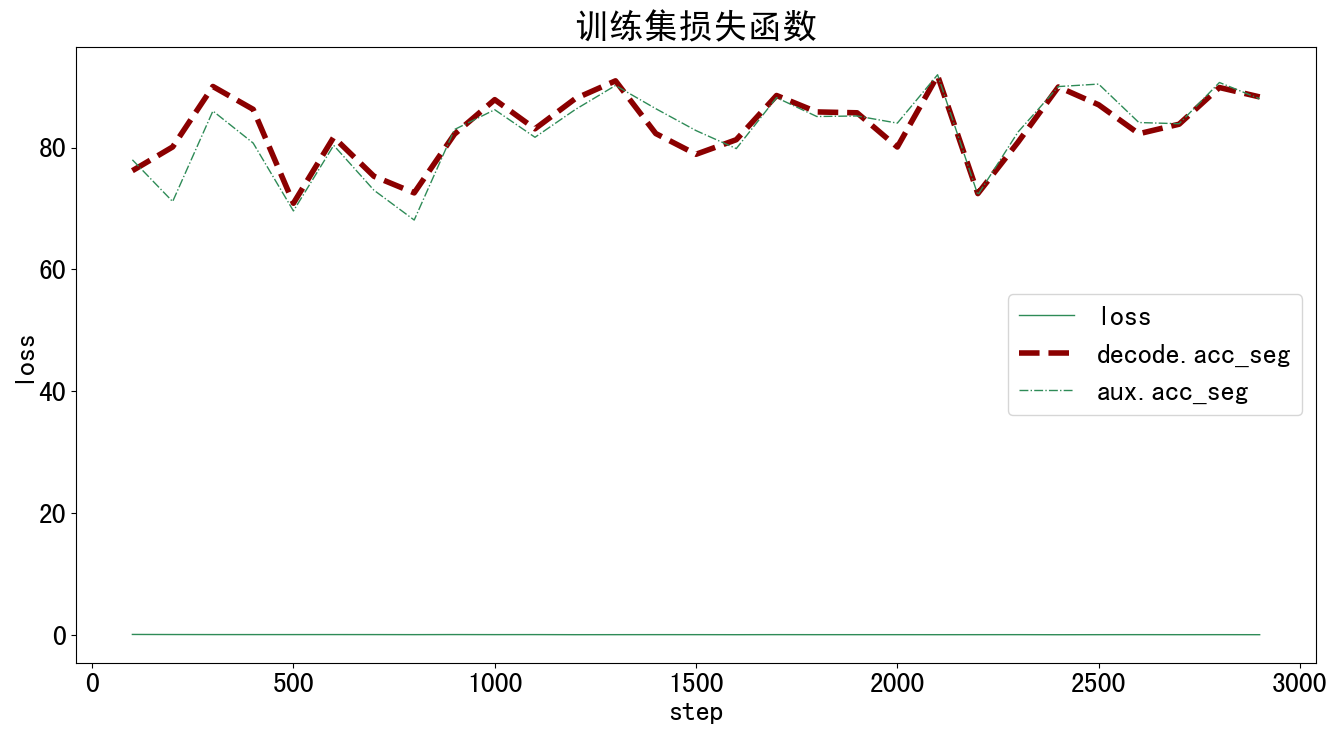

In [22]:
metrics = ['loss', 'decode.acc_seg', 'aux.acc_seg']
plt.figure(figsize=(16, 8))
x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())
plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('训练集损失函数', fontsize=25)
plt.legend(fontsize=20)
plt.show()

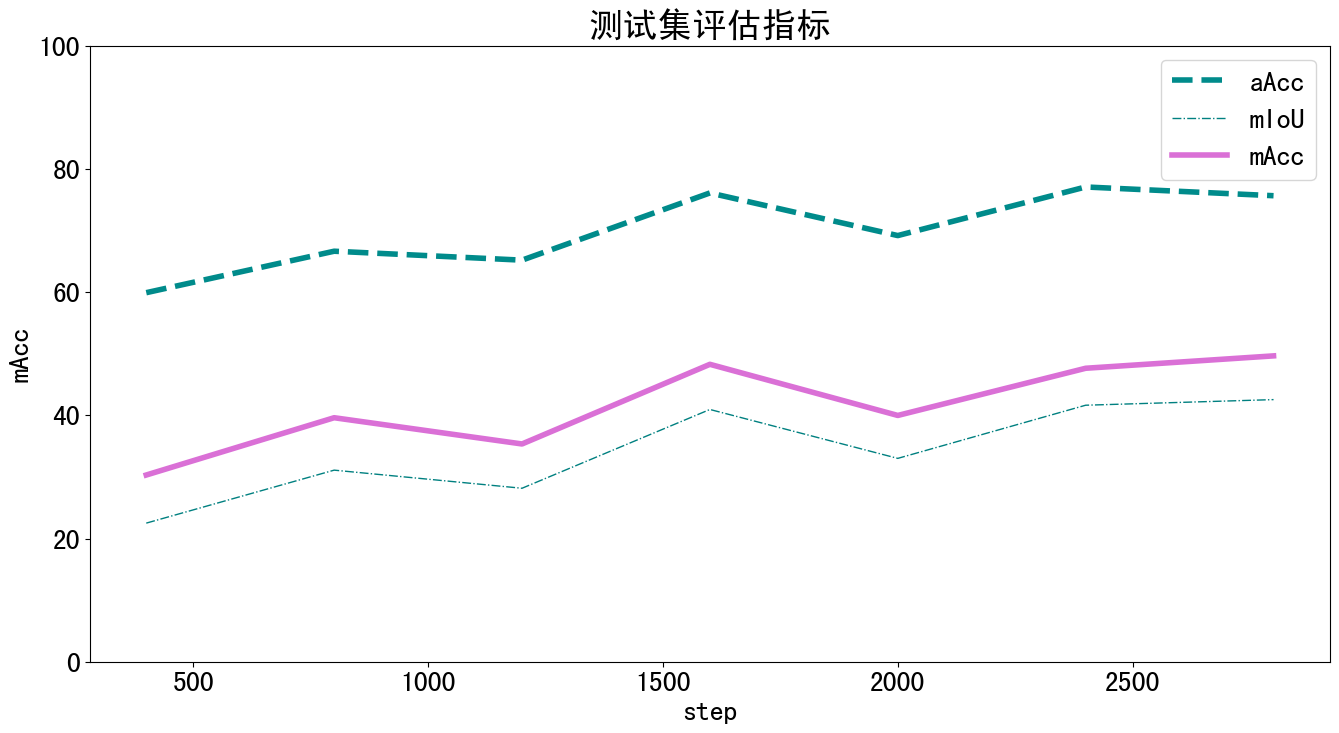

In [23]:
metrics = ['aAcc', 'mIoU', 'mAcc']
plt.figure(figsize=(16, 8))
x = df_test['step']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())
plt.tick_params(labelsize=20)
plt.ylim([0, 100])
plt.xlabel('step', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('测试集评估指标', fontsize=25)
plt.legend(fontsize=20)
plt.show()

In [24]:
# 1.4 单张图片和视频测试
!python demo/image_demo.py \
        data/watermelon01.jpeg \
        configs/pspnet/pspnet_r50-d8_4xb2-40k_watermelon.py \
        work_dirs/Watermelon87Dataset/iter_3000.pth \
        --out-file outputs/watermelon01.jpg \
        --device cuda:0 \
        --opacity 0.5

/bin/bash: /home/worker20/.conda/envs/MMPose/lib/python3.8/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: work_dirs/Watermelon87Dataset/iter_3000.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.co

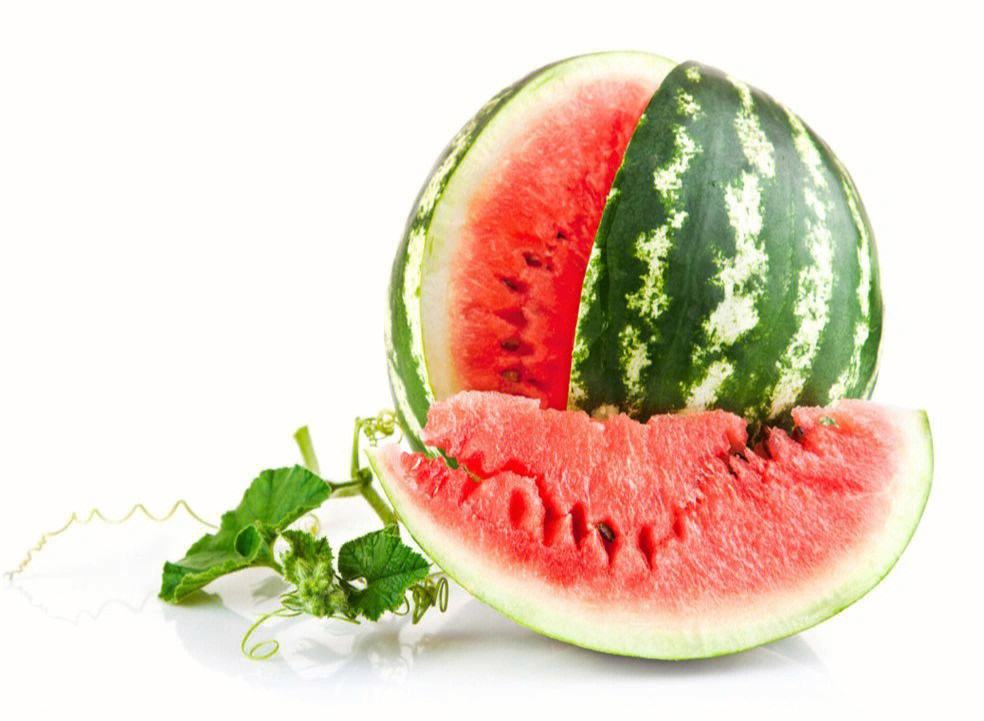

In [27]:
Image.open('data/watermelon01.jpeg')

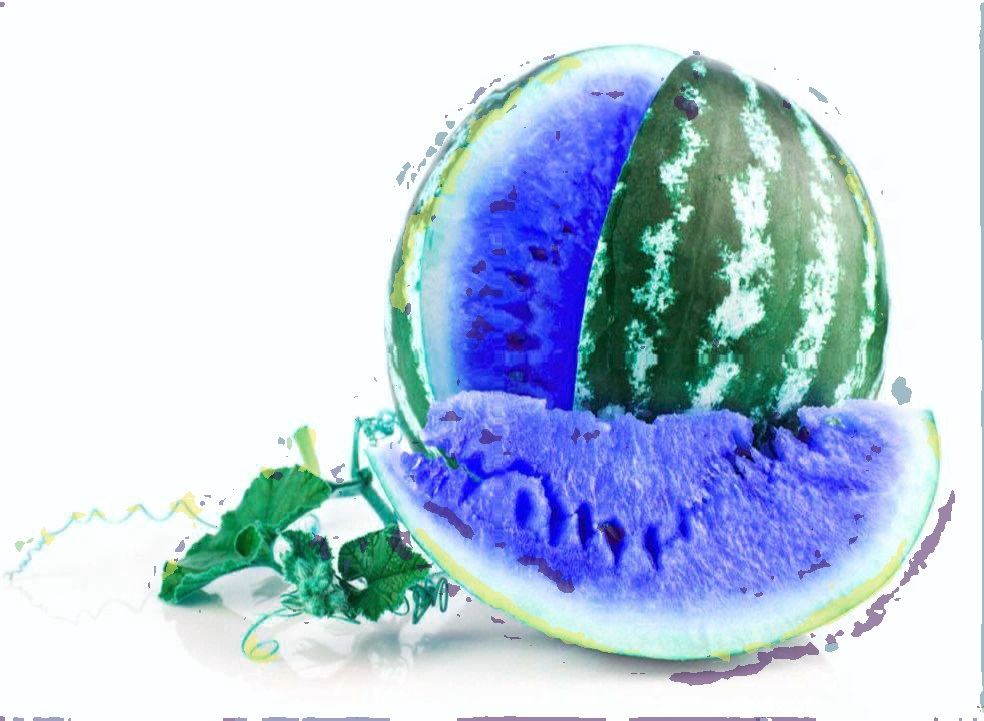

In [26]:
Image.open('outputs/watermelon01.jpg')

In [2]:
!python demo/video_demo.py \
        data/watermelon02.mp4 \
        configs/pspnet/pspnet_r50-d8_4xb2-40k_watermelon.py \
        work_dirs/Watermelon87Dataset/iter_3000.pth \
        --device cuda:0 \
        --output-file outputs/watermelon_02.mp4 \
        --opacity 0.5

/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/files/OpenMMlabAI/MMSegmentation/MMSegmentation_Tutorials-main/20230612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: work_dirs/Watermelon87Dataset/iter_3000.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([19, 512, 1, 1]).
size mismatch for de